# Homework  01

Use the provided datafile and complete the following steps. Complete the assignment within a .ipynb notebook. Submit either the .ipynb, .html, or .pdf of the results.

GitHub link to homework & assignments

# Import packages

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandasql import sqldf
import sklearn.metrics as sk_metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf

import torch
import torch.nn as nn
import torch.optim as optim



# Read data

Step 1. Import the data from the given .csv file (diabetes.csv Download diabetes.csv). The first few columns contain the data while the last column is a binary class label of 0 or 1

In [4]:
cols = [f"feat{i}" for i in range(1,9)]
target = ['label']
data = pd.read_csv("diabetes.csv",
                   header=None,
                   index_col=False,
                   names=cols + target)


# EDA

Step 2. Preprocess the data as you see fit and show basic data visualization for better understanding of data

In [6]:
display(data.head())
display(data.tail())

,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,label
0,-0.294118,0.487437,0.180328,-0.292929,0.000000,0.001490,-0.531170,-0.033333,0
1,-0.882353,-0.145729,0.081967,-0.414141,0.000000,-0.207153,-0.766866,-0.666667,1
2,-0.058824,0.839196,0.049180,0.000000,0.000000,-0.305514,-0.492741,-0.633333,0
3,-0.882353,-0.105528,0.081967,-0.535354,-0.777778,-0.162444,-0.923997,0.000000,1
4,0.000000,0.376884,-0.344262,-0.292929,-0.602837,0.284650,0.887276,-0.600000,0


,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,label
754,0.176471,0.015075,0.245902,-0.030303,-0.574468,-0.019374,-0.920581,0.400000,1
755,-0.764706,0.226131,0.147541,-0.454545,0.000000,0.096870,-0.776260,-0.800000,1
756,-0.411765,0.216080,0.180328,-0.535354,-0.735225,-0.219076,-0.857387,-0.700000,1
757,-0.882353,0.266332,-0.016393,0.000000,0.000000,-0.102832,-0.768574,-0.133333,0
758,-0.882353,-0.065327,0.147541,-0.373737,0.000000,-0.093890,-0.797609,-0.933333,1


Initial visual ispection of data to observe quality in terms of data type quality in the header and footer.

In [7]:
data.shape #(759, 9)
data.isnull().sum() # no nulls
data.info() #all feature variables are floats, class label is int

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 759 entries, 0 to 758
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   feat1   759 non-null    float64
 1   feat2   759 non-null    float64
 2   feat3   759 non-null    float64
 3   feat4   759 non-null    float64
 4   feat5   759 non-null    float64
 5   feat6   759 non-null    float64
 6   feat7   759 non-null    float64
 7   feat8   759 non-null    float64
 8   label   759 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 53.5 KB


With strictly all continous feature variables and 1 categorical binary variable, the use case could be defined as a multivariate classification.

In [8]:
data.nunique() 

feat1     17
feat2    136
feat3     46
feat4     51
feat5    184
feat6    248
feat7    515
feat8     51
label      2
dtype: int64

check for cardinality. as expected, target class should have only 2 distinct values, and other continous variables are expected to have higher cardinality

,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,label
count,759.000000,759.000000,759.000000,759.000000,759.000000,759.000000,759.000000,759.000000,759.000000
mean,-0.407657,0.218563,0.176505,-0.289735,-0.323534,-0.032245,-0.663253,-0.516162,0.653491
std,0.386260,0.306419,0.201287,0.258480,0.375544,0.205376,0.283056,0.400794,0.476171
min,-0.882353,-0.557789,-0.606557,-0.858586,-0.966903,-0.457526,-0.994876,-0.966667,0.000000
25%,-0.764706,-0.005025,0.016393,-0.494949,-0.716312,-0.178837,-0.858241,-0.866667,0.000000
50%,-0.529412,0.165829,0.180328,-0.292929,0.000000,-0.034277,-0.747225,-0.633333,1.000000
75%,0.000000,0.407035,0.311475,0.000000,0.000000,0.087929,-0.531597,-0.233333,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<Axes: >

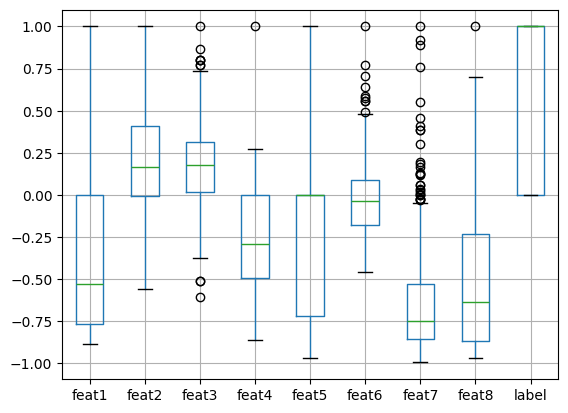

In [9]:
display(data.describe())

data.boxplot()

Assess range and distribution of data's numerical columns by looking at IQR
- max values for all columns are 1.0
- min values can measure in the negatives for all feature columns
- lower bound > -1.0, upper bound =  1.0
- mean values, 25% and 75% can vary among all feature columns
- there appears to be outliers beyond (Q3 + 1.5 * IQR) in feats 3,4,6,7, & 8
- only feat3 has outliers below (Q1 - 1.5 * IQR)

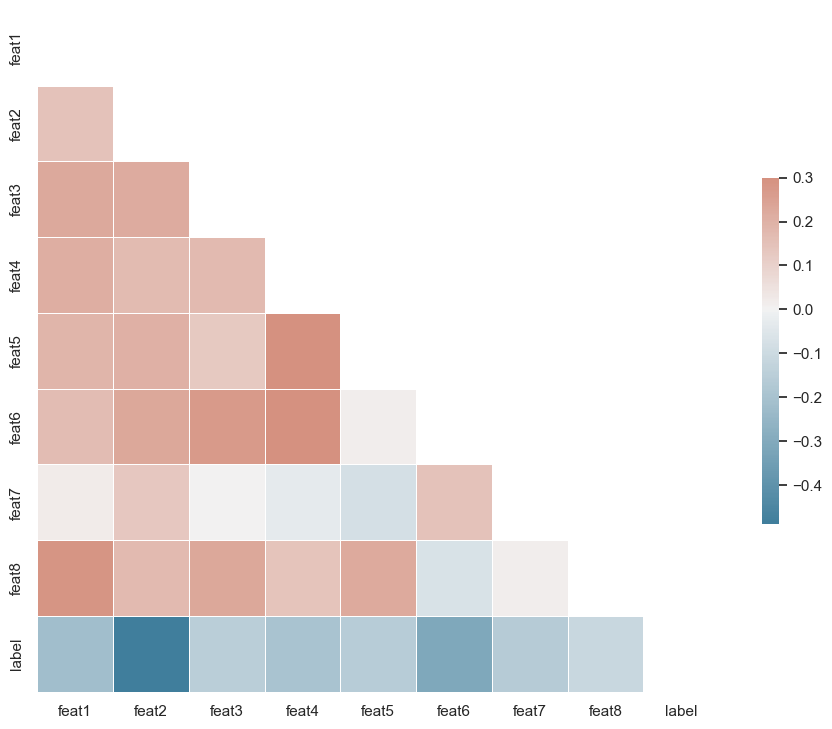

In [10]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

Pairwise correlations among the feature varialbes range from 0 to a small value of 0.3. Multicollinearity may not be a big concern during modeling. With respect to the label column, feat2, and feat6 are observed to higher associations with the target class relative to other features.

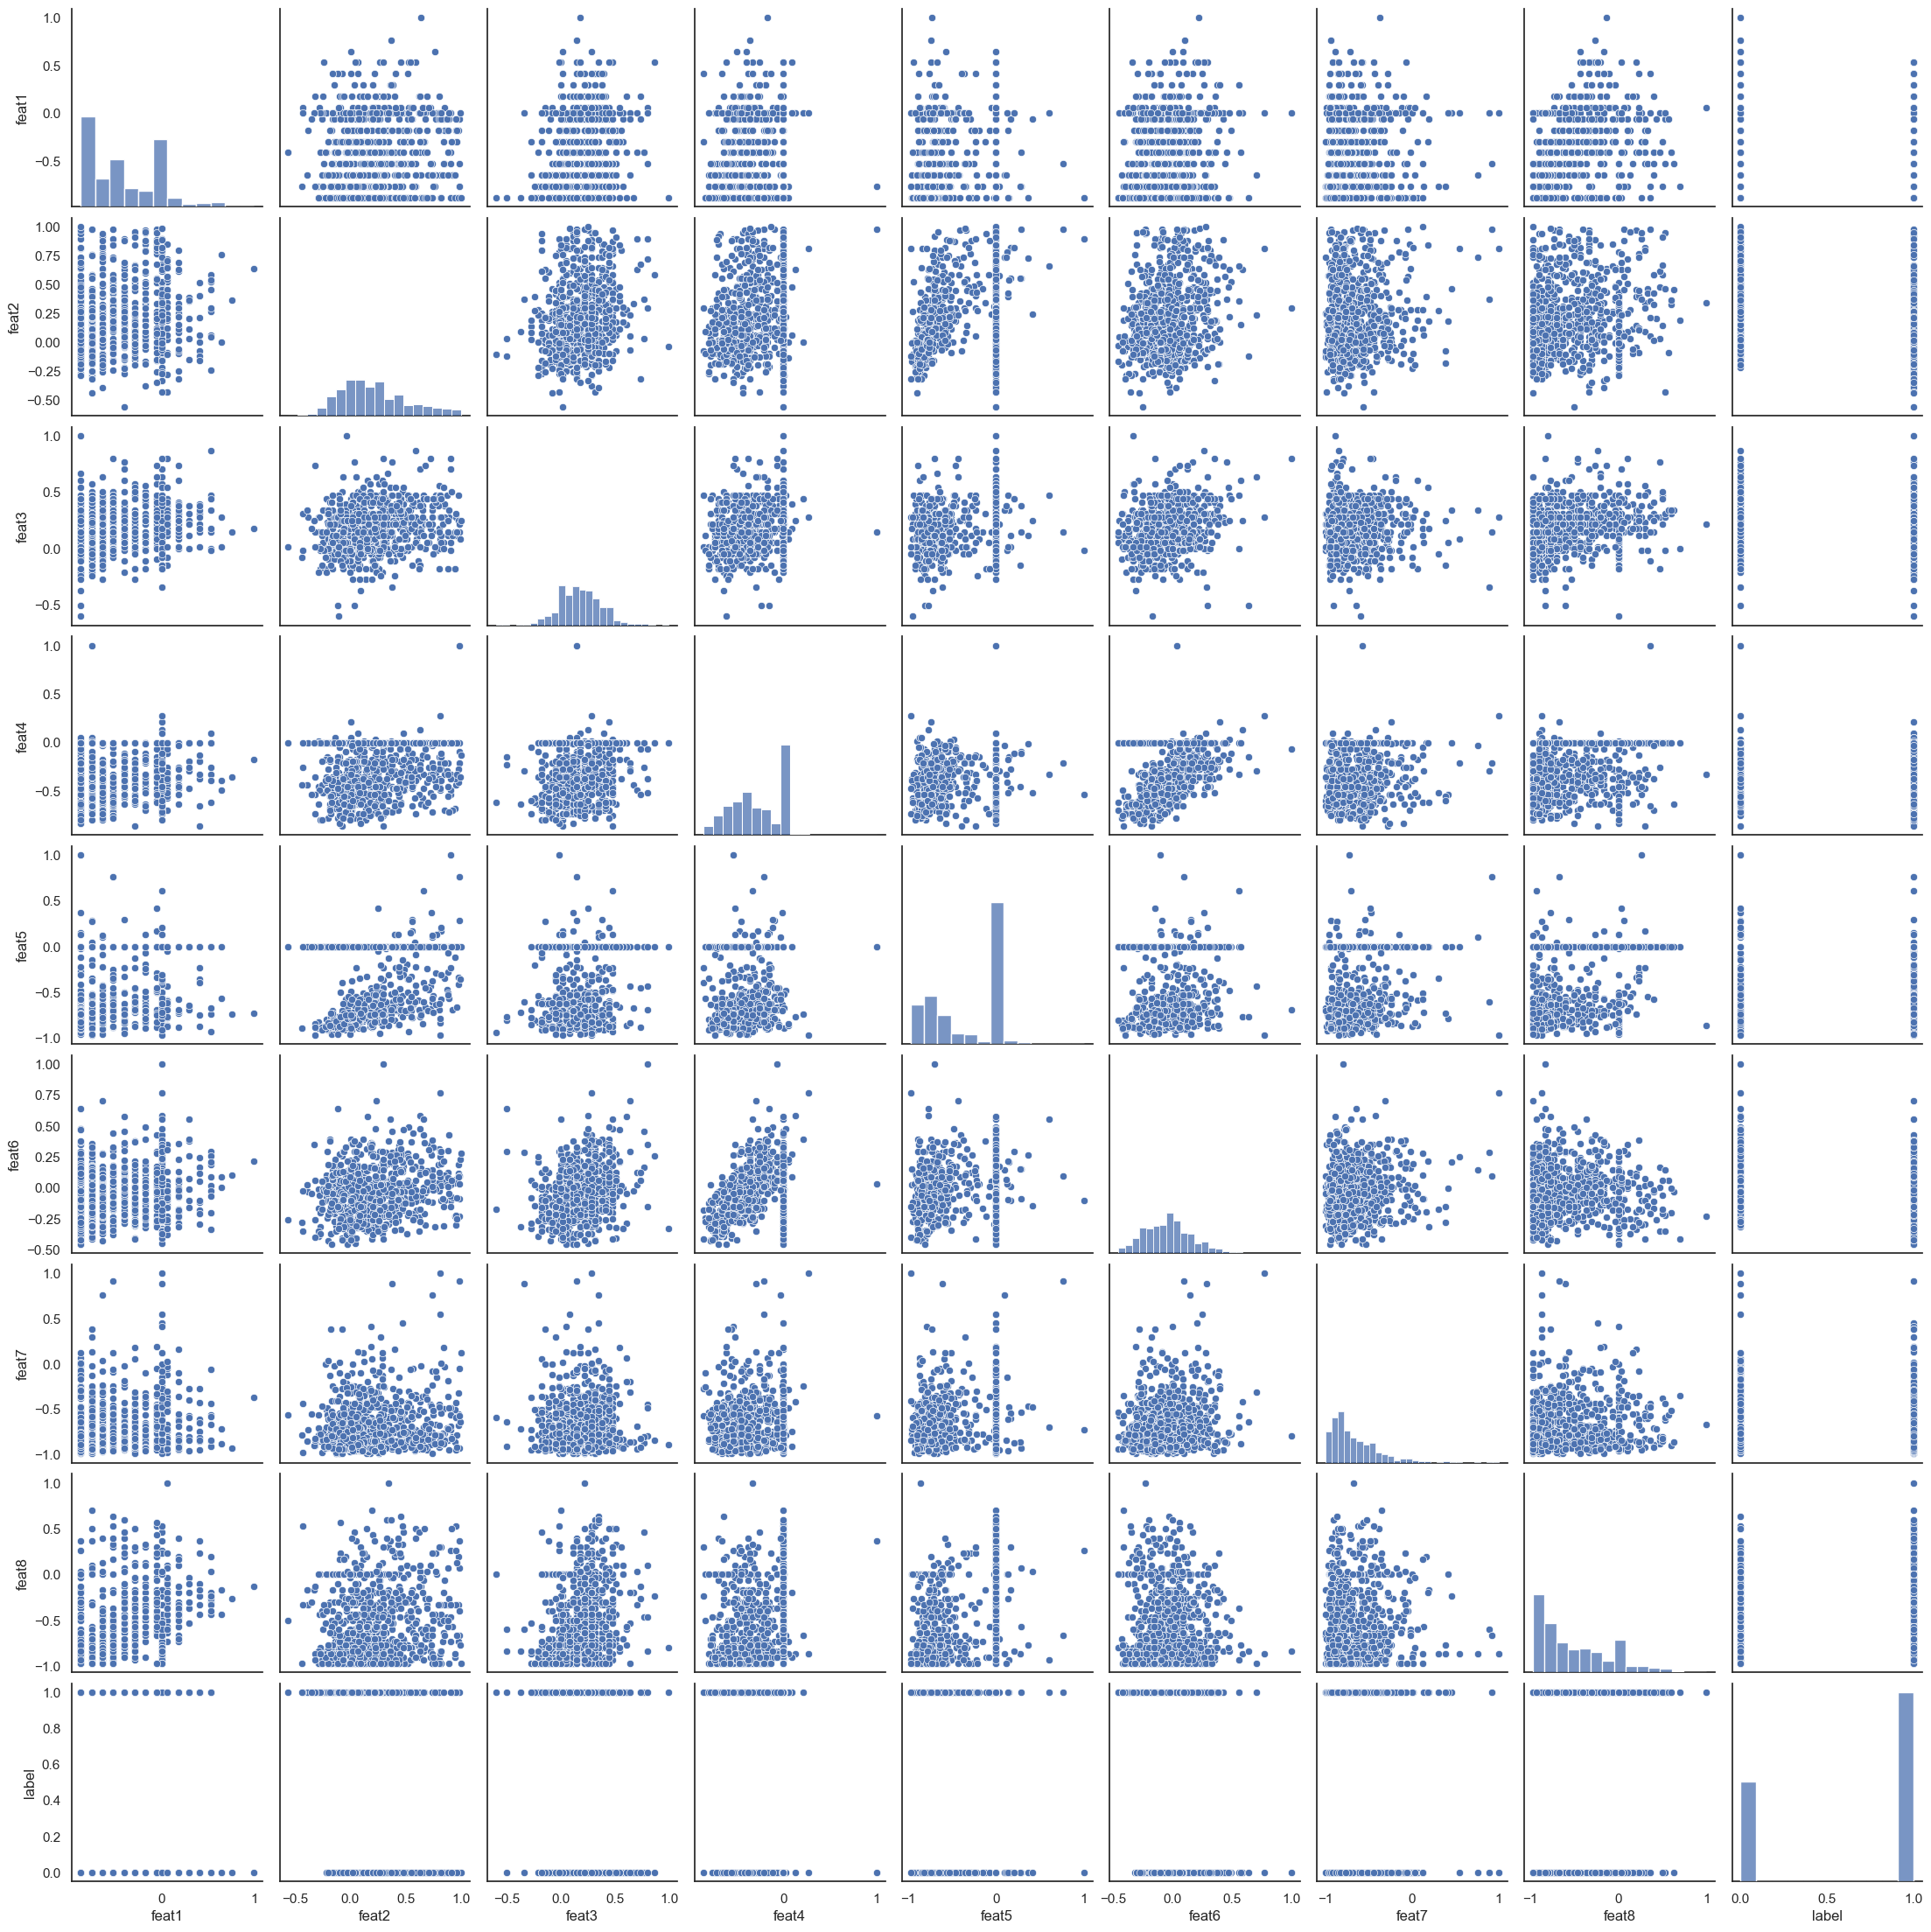

In [11]:
sns.pairplot(data=data)
plt.show()

A pairplot displays the pairwise/joint relationships in the dataset between each of the feature variables together and in relation with the target. Along the main diagonal are the univariate distribution as a histogram of each feature.
- feat1 has a bimodal distribution with 2 apparent peaks
- feat2,6,7, and 8 are right-skewed whereas feat4 and 5 are heavily left-skewed
- feat3 appears almost bell-shaped or normally distributed


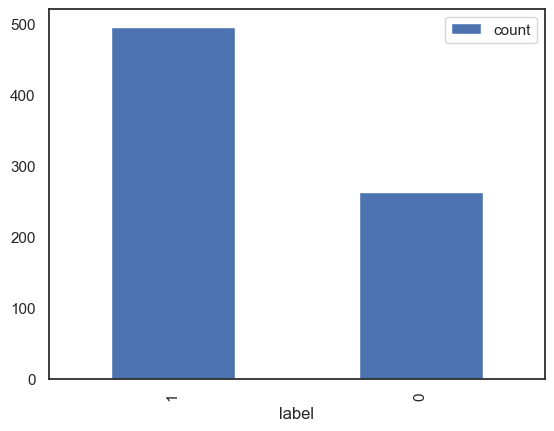

In [12]:
data['label'].value_counts().to_frame('count').plot.bar()
plt.show()

There appears to be a class imbalance. The dataset might require a rebalance of classes as to not introduce biasness to the potential fitted model.

In [13]:
group_avg = sqldf("select " + ', '.join([f"avg(feat{i}) as avg_feat{i}" for i in range(1,9)]) + " from data group by label").T
group_avg = group_avg.assign(diff = group_avg[0] - group_avg[1])
group_avg.sort_values('diff',ascending=False)

,0,1,diff
avg_feat2,0.423964,0.109651,0.314313
avg_feat1,-0.291881,-0.469047,0.177165
avg_feat6,0.055810,-0.078935,0.134746
avg_feat5,-0.241665,-0.366945,0.125280
avg_feat4,-0.220571,-0.326409,0.105839
avg_feat7,-0.599838,-0.696878,0.097040
avg_feat8,-0.454246,-0.548992,0.094746
avg_feat3,0.218413,0.154283,0.064130


The central tendencies for the features stratified by label class differs slightly across the board. At an initial glance of explcit differences, the central tendencies for feat2 may be most significant

# Train/Test Split

Step 3. Split into 80% train 20% test

- Code borrowed from [TensorFlow documentation](https://www.tensorflow.org/guide/core/logistic_regression_core)

In [14]:
train_dataset = data.sample(frac=0.80, random_state=1)
len(train_dataset)


607

In [15]:
test_dataset = data.drop(train_dataset.index)
len(test_dataset)


152

In [16]:
train_dataset

,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,label
480,0.000000,0.738693,0.278689,-0.353535,-0.373522,0.385991,-0.076857,0.233333,1
622,-0.176471,0.145729,0.049180,0.000000,0.000000,-0.183308,-0.441503,-0.566667,0
638,-0.882353,0.678392,0.213115,-0.656566,-0.659574,-0.302534,-0.684885,-0.600000,0
389,-0.529412,0.587940,0.278689,0.000000,0.000000,-0.019374,-0.380871,-0.666667,0
748,0.000000,0.236181,0.180328,0.000000,0.000000,0.081967,-0.846285,0.033333,0
...,...,...,...,...,...,...,...,...,...
325,-0.058824,0.185930,0.180328,-0.616162,0.000000,-0.311475,0.193851,-0.166667,1
199,-0.882353,0.386935,0.344262,0.000000,0.000000,0.195231,-0.865073,-0.766667,1
450,-0.882353,0.356784,-0.114754,0.000000,0.000000,-0.204173,-0.479932,0.366667,1
137,-0.411765,0.055276,0.180328,-0.414141,-0.231678,0.099851,-0.930828,-0.766667,1


In [17]:
X = data.drop('label',axis=1).values
y = data['label'].values

x_train, y_train = train_dataset.iloc[:, 0:len(data.columns)-1], train_dataset['label']
x_test, y_test = test_dataset.iloc[:, 0:len(data.columns)-1], test_dataset['label']


## Additional EDA on training set

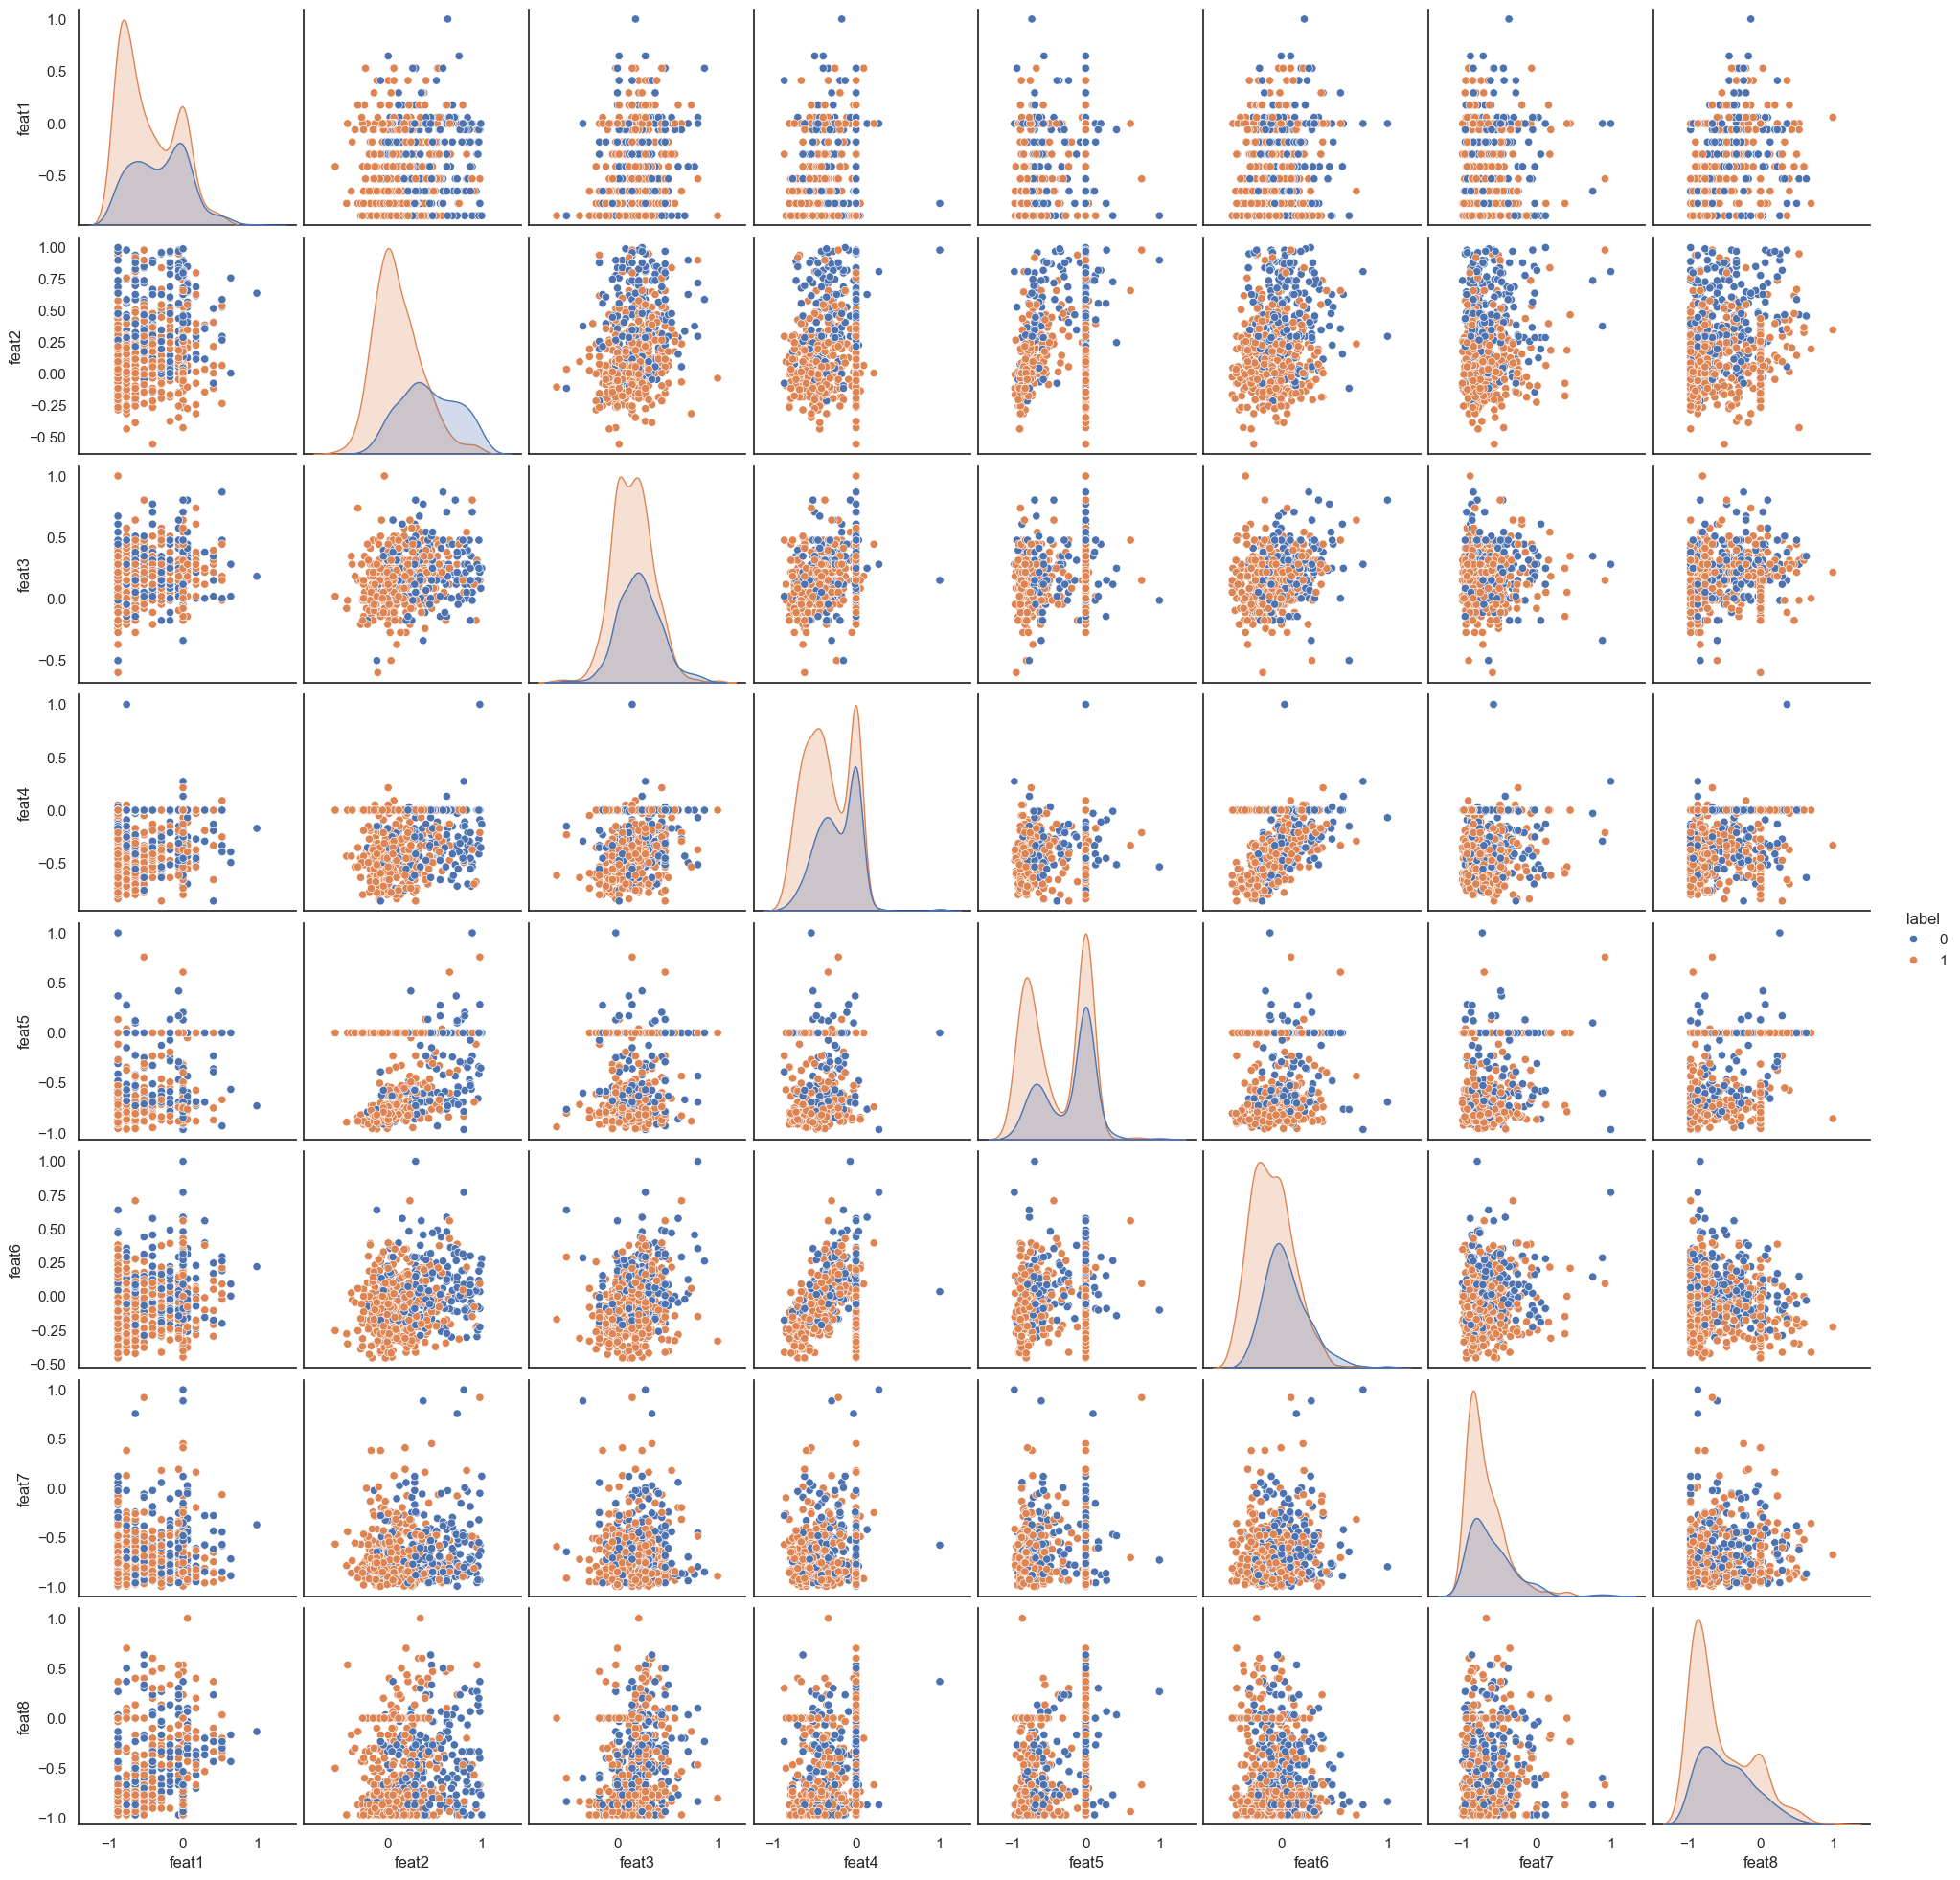

In [18]:
sns.pairplot(train_dataset, hue = 'label', diag_kind='kde')
plt.show()

By plotting the joint distributions of the pairs of features from the training set, relative to the label class, it can be observed how significant the correlations may appear. The diagnosis classes are more right-skewed for the majority of the features

Given the same scale of values, ranging from -1 to 1, standardization may be not required as a preprocessing step. Though, normalization is still an option

# Part 1 - TensorFlow


### preprocess training and testing sets

In [149]:
#convert to tensor
x_train, y_train = tf.convert_to_tensor(x_train, dtype=tf.float32), tf.convert_to_tensor(y_train, dtype=tf.float32)
x_test, y_test = tf.convert_to_tensor(x_test, dtype=tf.float32), tf.convert_to_tensor(y_test, dtype=tf.float32)

## First Iteration - following in-class demo

Step 4. Modify the model shown in the demo to take the new data

- code borrowed from [packt](https://subscription.packtpub.com/book/data/9781789132212/1/ch01lvl1sec15/logistic-regression-with-keras)

In [20]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation=tf.nn.softmax)
])

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16,activation='sigmoid',input_shape=[8,]),
    tf.keras.layers.Dense(16,activation='relu'),
    tf.keras.layers.Dense(1),
    #tf.keras.layers.Dense(16, activation=tf.nn.softmax)
])

#### Metrics: Accuracy

In [30]:
model.compile(optimizer='sgd',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 32)                288       
                                                                 
 dense_8 (Dense)             (None, 32)                1056      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1377 (5.38 KB)
Trainable params: 1377 (5.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
model.fit(x_train, y_train, epochs=5)
tf_logr_predict = model.predict(x_train)
model.evaluate(x_test, y_test)


Epoch 1/5
19/19 [==============================] - 0s 606us/step - loss: 2.9824 - accuracy: 0.0049
Epoch 2/5
19/19 [==============================] - 0s 458us/step - loss: 2.7696 - accuracy: 0.0181
Epoch 3/5
19/19 [==============================] - 0s 469us/step - loss: 2.5693 - accuracy: 0.1071
Epoch 4/5
19/19 [==============================] - 0s 434us/step - loss: 2.3831 - accuracy: 0.3361
Epoch 5/5
5/5 [==============================] - 0s 722us/step - loss: 2.1482 - accuracy: 0.5855


[2.148214817047119, 0.5855262875556946]

Although each iteration produces different results due to batching, by increasing the number of epochs, the testing accuracy increases slightly with minor variations.

#### Metrics: MSE

In [31]:
model.compile(optimizer='SGD',
loss= tf.keras.losses.MeanSquaredError(),
metrics=['mean_squared_error'])

print(model.summary())

model.fit(x_train, y_train, epochs=5)
#tf_logr_predict = model.predict(x_train)
model.evaluate(x_test, y_test)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 32)                288       
                                                                 
 dense_8 (Dense)             (None, 32)                1056      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1377 (5.38 KB)
Trainable params: 1377 (5.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/5
19/19 [==============================] - 0s 563us/step - loss: 0.2251 - mean_squared_error: 0.2251
Epoch 2/5
19/19 [==============================] - 0s 530us/step - loss: 0.2231 - mean_squared_error: 0.2231
Epoch 3/5
19/19 [==============================] - 0s 549us/ste

[0.22821778059005737, 0.22821778059005737]

Optimizing for MSE metric results in a lower performance than the initial Accuracy metrics selection

#### Activation: relu

In [32]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16,activation='sigmoid',input_shape=[8,]),
    tf.keras.layers.Dense(16,activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam',
                     loss=tf.keras.losses.MeanSquaredError(),
                     metrics=['mean_squared_error'])

print(model.summary())

model.fit(x_train, y_train, epochs=10)
model.evaluate(x_test, y_test)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 16)                144       
                                                                 
 dense_11 (Dense)            (None, 16)                272       
                                                                 
 dense_12 (Dense)            (None, 1)                 17        
                                                                 
Total params: 433 (1.69 KB)
Trainable params: 433 (1.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None
Epoch 1/10
19/19 [==============================] - 0s 608us/step - loss: 0.3091 - mean_squared_error: 0.3091
Epoch 2/10
19/19 [==============================] - 0s 539us/step - loss: 0.2298 - mean_squared_error: 0.2298
Epoch 3/10
19/19 [==============================] - 0s 514us/step - loss: 0.2193 - mean_squared_error: 0.2193
Epoch 4/10
19/19 [==============================] - 0s 494us/step - loss: 0.2128 - mean_squared_error: 0.2128
Epoch 5/10
19/19 [==============================] - 0s 482us/step - loss: 0.2072 - mean_squared_error: 0.2072
Epoch 6/10
19/19 [==============================] - 0s 472us/step - loss: 0.2011 - mean_squared_error: 0.2011
Epoch 7/10
19/19 [==============================] - 0s 469us/step - loss: 0.1963 - mean_squared_error: 0.1963
Epoch 8/10
19/19 [==============================] - 0s 471us/step - loss: 0.1906 - mean_squared_error: 0.1906
Epoch 9/10
19/19 [==============================] - 0s 472us/step - loss: 0.1861 - mean_squared_error: 0.1861
Epoch

[0.19699330627918243, 0.19699330627918243]

lowest performance is observed with modifications to the activation function as relu and optimizer as adam

### Hypothesis: Expanding the number of neurons could enable the model's ability to learn patterns in the data, that was originally feasible with a lower number of neurons. This could lead to improved performances.

In [33]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32,activation='sigmoid',input_shape=[8,]),
    tf.keras.layers.Dense(32,activation=tf.nn.softmax),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam',
                     loss=tf.keras.losses.MeanSquaredError(),
                     metrics=['mean_squared_error'])

print(model.summary())

model.fit(x_train, y_train, epochs=10)
model.evaluate(x_test, y_test)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 32)                288       
                                                                 
 dense_14 (Dense)            (None, 32)                1056      
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1377 (5.38 KB)
Trainable params: 1377 (5.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None
Epoch 1/10
19/19 [==============================] - 0s 646us/step - loss: 0.6530 - mean_squared_error: 0.6530
Epoch 2/10
19/19 [==============================] - 0s 607us/step - loss: 0.5239 - mean_squared_error: 0.5239
Epoch 3/10
19/19 [==============================] - 0s 517us/step - loss: 0.4284 - mean_squared_error: 0.4284
Epoch 4/10
19/19 [==============================] - 0s 539us/step - loss: 0.3570 - mean_squared_error: 0.3570
Epoch 5/10
19/19 [==============================] - 0s 524us/step - loss: 0.3075 - mean_squared_error: 0.3075
Epoch 6/10
19/19 [==============================] - 0s 513us/step - loss: 0.2752 - mean_squared_error: 0.2752
Epoch 7/10
19/19 [==============================] - 0s 520us/step - loss: 0.2541 - mean_squared_error: 0.2541
Epoch 8/10
19/19 [==============================] - 0s 518us/step - loss: 0.2403 - mean_squared_error: 0.2403
Epoch 9/10
19/19 [==============================] - 0s 494us/step - loss: 0.2315 - mean_squared_error: 0.2315
Epoch

[0.22862298786640167, 0.22862298786640167]

By expanding the depth of the NN to 32 neurons per base layer, we see a minor improvement in accuracy but slightly higher MSE loss metric

In [34]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(24,activation='sigmoid',input_shape=[8,]),
    tf.keras.layers.Dense(24,activation=tf.nn.softmax),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam',
                     loss=tf.keras.losses.MeanSquaredError(),
                     metrics=['mean_squared_error'])

print(model.summary())

model.fit(x_train, y_train, epochs=10)
model.evaluate(x_test, y_test)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 24)                216       
                                                                 
 dense_17 (Dense)            (None, 24)                600       
                                                                 
 dense_18 (Dense)            (None, 1)                 25        
                                                                 
Total params: 841 (3.29 KB)
Trainable params: 841 (3.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
19/19 [==============================] - 0s 648us/step - loss: 0.6908 - mean_squared_error: 0.6908
Epoch 2/10
19/19 [==============================] - 0s 605us/step - loss: 0.5567 - mean_squared_error: 0.5567
Epoch 3/10
19/19 [==============================] - 0s 615us/st

[0.22838100790977478, 0.22838100790977478]

Increasing the number of neurons by 50% from the baseline network architecture of 16 continues to yield similar performances. At some point, redudancy is introduced with scaling the number of neurons at the expense of greater number of neurons. Depending on the complexity and nature of the training set, a smaller number of neurons may suffice for building a constrained model, structured by its input dataset.

# Part 2 - PyTorch


In [25]:
inputs = x_train.values
outputs = y_train.values

input_tensor = torch.from_numpy(inputs.astype(np.float32))
output_tensor = torch.from_numpy(outputs.astype(np.float32))


In [26]:

model = nn.Sequential(
    nn.Linear(8, 16),  
    nn.Sigmoid(),
    nn.Linear(16,16),
    nn.ReLU(),  
    nn.Linear(16, 1),  
    nn.Sigmoid()  
)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)


for epoch in range(20):
  
  permutation = torch.randperm(input_tensor.size()[0])
  for i in range(0,inputs.shape[0],32):
        indices = permutation[i:i+32]

        X = input_tensor[indices]
        y_true = output_tensor[indices]

        optimizer.zero_grad()
        
        y_pred = model(X)
        loss = criterion(y_pred, y_true)
        loss.backward()
        optimizer.step()

        acc = (y_pred.round() == y_true).float().mean()
       
        print(f'{epoch + 1} loss: {loss}, acc: {acc}')


print('Finished Training')

1 loss: 0.24683700501918793, acc: 0.6875
1 loss: 0.24779313802719116, acc: 0.625
1 loss: 0.24473202228546143, acc: 0.78125
1 loss: 0.24691200256347656, acc: 0.65625
1 loss: 0.24746614694595337, acc: 0.625
1 loss: 0.2464750111103058, acc: 0.65625
1 loss: 0.2426370084285736, acc: 0.8125
1 loss: 0.24537472426891327, acc: 0.6875
1 loss: 0.2461654543876648, acc: 0.65625
1 loss: 0.24679866433143616, acc: 0.625
1 loss: 0.246670663356781, acc: 0.625
1 loss: 0.24653851985931396, acc: 0.625
1 loss: 0.24639689922332764, acc: 0.625
1 loss: 0.2502214312553406, acc: 0.5
1 loss: 0.24834495782852173, acc: 0.5625
1 loss: 0.2443944662809372, acc: 0.6875
1 loss: 0.2463882863521576, acc: 0.625
1 loss: 0.24509428441524506, acc: 0.65625
1 loss: 0.2412090003490448, acc: 0.774193525314331
2 loss: 0.25135961174964905, acc: 0.46875
2 loss: 0.24498476088047028, acc: 0.65625
2 loss: 0.24808155000209808, acc: 0.5625
2 loss: 0.23938581347465515, acc: 0.8125
2 loss: 0.24571530520915985, acc: 0.625
2 loss: 0.24675580

/Users/christopherton/Desktop/SJSU_MSDA/255/venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/christopherton/Desktop/SJSU_MSDA/255/venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


# Experimentation for model improvement

Step 8 & 9. Hypothesize changes you can make to the model. Type out your hypothesis as comments in the code or in a text cell. (ex. doubling the width/depth of your NN, experiment thoroughly). Test hypotheses by training new models

It is often by trial and error that optimal model parameters are selected for accurate inferences. By increasing the number of training iterations and steps, a process for evaluating the performance on training and unseen data can be inferred.

However, we can simply begin by acknowledging the unbalanced distribution of target classes and rebalance during train test split

### TensorFlow

In [ ]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

### PyTorch

In [478]:

X = data.drop('label',axis=1).values
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)


X_train_tensor = torch.from_numpy(X_train.astype(np.float32))
y_train_tensor = torch.from_numpy(y_train.astype(np.float32))

X_test_tensor = torch.from_numpy(X_test.astype(np.float32))
y_test_tensor = torch.from_numpy(y_test.astype(np.float32))


model = nn.Sequential(
    nn.Linear(8, 16),
    #nn.BatchNorm1d(16),
    nn.Sigmoid(),
    nn.Linear(16,16),
    #nn.BatchNorm1d(16),
    nn.ReLU(),  
    nn.Linear(16, 1),  
    nn.Sigmoid()  
)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

epochs = 100


for epoch in range(epochs):
  
  permutation = torch.randperm(input_tensor.size()[0])
  for i in range(0,inputs.shape[0],32):
        indices = permutation[i:i+32]

        X = input_tensor[indices]
        y_true = output_tensor[indices]

        optimizer.zero_grad()
        
        y_pred = model(X)
        loss = criterion(y_pred, y_true)
        loss.backward()
        optimizer.step()

        acc = (y_pred.round() == y_true).float().mean()
       
        print(f'{epoch + 1} loss: {loss}, acc: {acc}')


print('Finished Training')


/Users/christopherton/Desktop/SJSU_MSDA/255/venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/christopherton/Desktop/SJSU_MSDA/255/venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1 loss: 0.2907189130783081, acc: 0.3125
1 loss: 0.3006291687488556, acc: 0.25
1 loss: 0.2889457046985626, acc: 0.3125
1 loss: 0.30916473269462585, acc: 0.1875
1 loss: 0.2826748788356781, acc: 0.34375
1 loss: 0.27216604351997375, acc: 0.40625
1 loss: 0.27226948738098145, acc: 0.40625
1 loss: 0.29124268889427185, acc: 0.28125
1 loss: 0.28537049889564514, acc: 0.3125
1 loss: 0.2895815968513489, acc: 0.28125
1 loss: 0.2753066420555115, acc: 0.375
1 loss: 0.28957876563072205, acc: 0.28125
1 loss: 0.26479342579841614, acc: 0.4375
1 loss: 0.2695247530937195, acc: 0.40625
1 loss: 0.2830098271369934, acc: 0.3125
1 loss: 0.28253835439682007, acc: 0.3125
1 loss: 0.25987279415130615, acc: 0.46875
1 loss: 0.2727951407432556, acc: 0.375
1 loss: 0.2617782950401306, acc: 0.4516128897666931
2 loss: 0.27720171213150024, acc: 0.34375
2 loss: 0.26785245537757874, acc: 0.40625
2 loss: 0.2719886302947998, acc: 0.375
2 loss: 0.2674061059951782, acc: 0.40625
2 loss: 0.2627973258495331, acc: 0.4375
2 loss: 0.2

A couple improvement steps are taken at this iteration for model improvement. By stratifying the dataset during train-test split, we can ensure that no bias is introduced to the model. If the unbalanced nature is persisted, the model may not generalize well for the the minority class. We inlcude the `stratify` parameter and name the y target variable as the factor for splitting.

Additionally, by increasing the number of epochs from 20 to 100, the accuracy noticably improves while loss metric degrades.

In [480]:

model = nn.Sequential(
    nn.Linear(8, 32),
    #nn.BatchNorm1d(16),
    nn.Sigmoid(),
    nn.Linear(32,32),
    #nn.BatchNorm1d(16),
    nn.ReLU(),  
    nn.Linear(32, 1),  
    nn.Sigmoid()  
)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

epochs = 200


for epoch in range(epochs):
  
  permutation = torch.randperm(input_tensor.size()[0])
  for i in range(0,inputs.shape[0],32):
        indices = permutation[i:i+32]

        X = input_tensor[indices]
        y_true = output_tensor[indices]

        optimizer.zero_grad()
        
        y_pred = model(X)
        loss = criterion(y_pred, y_true)
        loss.backward()
        optimizer.step()

        acc = (y_pred.round() == y_true).float().mean()
       
        print(f'{epoch + 1} loss: {loss}, acc: {acc}')


print('Finished Training')


1 loss: 0.24236400425434113, acc: 0.65625
1 loss: 0.24411344528198242, acc: 0.625
1 loss: 0.24049752950668335, acc: 0.6875
1 loss: 0.24724850058555603, acc: 0.5625
1 loss: 0.24207429587841034, acc: 0.65625
1 loss: 0.23955972492694855, acc: 0.6875
1 loss: 0.23575632274150848, acc: 0.75
1 loss: 0.24505621194839478, acc: 0.59375
1 loss: 0.23915280401706696, acc: 0.6875
1 loss: 0.23684275150299072, acc: 0.71875
1 loss: 0.24260203540325165, acc: 0.625
1 loss: 0.23822668194770813, acc: 0.6875
1 loss: 0.23796474933624268, acc: 0.6875
1 loss: 0.24458840489387512, acc: 0.59375
1 loss: 0.24438488483428955, acc: 0.59375
1 loss: 0.23958882689476013, acc: 0.65625
1 loss: 0.2443416267633438, acc: 0.59375
1 loss: 0.23490363359451294, acc: 0.71875
1 loss: 0.2349565327167511, acc: 0.7096773982048035
2 loss: 0.24169106781482697, acc: 0.625
2 loss: 0.2360733300447464, acc: 0.6875
2 loss: 0.2439163625240326, acc: 0.59375
2 loss: 0.23392389714717865, acc: 0.71875
2 loss: 0.2410835176706314, acc: 0.625
2 lo

In this experiment, the number of hidden layers is doubled and performance is not observed to change much drastically.

At some point, performance may converge or plateau despite increasing the number of compute resources.

However, preprocessing using standard scaling could help the performance of the model.

In [497]:


X = data.drop('label',axis=1).values
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_train_tensor = torch.from_numpy(X_train_scaled.astype(np.float32))
y_train_tensor = torch.from_numpy(y_train.astype(np.float32))

X_test_tensor = torch.from_numpy(X_test.astype(np.float32))
y_test_tensor = torch.from_numpy(y_test.astype(np.float32))


model = nn.Sequential(
    nn.Linear(8, 16),
    #nn.BatchNorm1d(16),
    nn.Sigmoid(),
    nn.Linear(16,16),
    #nn.BatchNorm1d(16),
    nn.ReLU(),  
    nn.Linear(16, 1),  
    nn.Sigmoid()  
)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

epochs = 20


for epoch in range(epochs):
  
  permutation = torch.randperm(input_tensor.size()[0])
  for i in range(0,inputs.shape[0],32):
        indices = permutation[i:i+32]

        X = input_tensor[indices]
        y_true = output_tensor[indices]

        optimizer.zero_grad()
        
        y_pred = model(X)
        loss = criterion(y_pred, y_true)
        loss.backward()
        optimizer.step()

        acc = (y_pred.round() == y_true).float().mean()
       
        print(f'{epoch + 1} loss: {loss}, acc: {acc}')


print('Finished Training')


1 loss: 0.24169804155826569, acc: 0.625
1 loss: 0.2391427755355835, acc: 0.65625
1 loss: 0.23900042474269867, acc: 0.65625
1 loss: 0.22885644435882568, acc: 0.78125
1 loss: 0.22605007886886597, acc: 0.8125
1 loss: 0.23585326969623566, acc: 0.6875
1 loss: 0.25457409024238586, acc: 0.46875
1 loss: 0.23846451938152313, acc: 0.65625
1 loss: 0.23308587074279785, acc: 0.71875
1 loss: 0.22751469910144806, acc: 0.78125
1 loss: 0.22382135689258575, acc: 0.8125
1 loss: 0.24640719592571259, acc: 0.5625
1 loss: 0.24352174997329712, acc: 0.59375
1 loss: 0.2435547411441803, acc: 0.59375
1 loss: 0.23496860265731812, acc: 0.6875
1 loss: 0.24925917387008667, acc: 0.53125
1 loss: 0.24058063328266144, acc: 0.625
1 loss: 0.24349695444107056, acc: 0.59375
1 loss: 0.23871096968650818, acc: 0.6451612710952759
2 loss: 0.23177829384803772, acc: 0.71875
2 loss: 0.2258220911026001, acc: 0.78125
2 loss: 0.25234901905059814, acc: 0.5
2 loss: 0.23432956635951996, acc: 0.6875
2 loss: 0.2311452031135559, acc: 0.71875

/Users/christopherton/Desktop/SJSU_MSDA/255/venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/christopherton/Desktop/SJSU_MSDA/255/venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Standardizing the input features may be conducive to the overall performance of the model by ensuring the explanatory variables all share a common scale. 